In [1]:
# the utils we'll be looking for

# we created groups
# we could calculate intersections
# we could infill groups with -1

# where is my interpolate and combine?

# the interval type seems realy handy as a multiindex with a float value field
    # multi type sleep data
    # single type data present/ not present  for various sensors
    # action intervals with various string descriptors

# is there a way for me to have multiple kinds of values for the value segment?

# start with the coded int intervals
    #how to keep the key? - let's just do it in the docs for now
# then extend to the action intervals

# how about the key for the coded int is the column name
#name+int!....

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import os
import sys

cwd = os.getcwd()
delimiter = "\\" if "\\" in cwd else "/"
repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
sys.path.append(repoPath + "dataImport/")
import rwWorkingTSDf
from rwWorkingTSDf import readWorkingTSDF, writeWorkingTSDf


In [3]:
def infillIntervals(intervals,col_name):
    # Shift columns to compare consecutive rows
    next_start = intervals['sampleDT'].shift(-1)

    # Find rows where there is a gap
    gap_mask = next_start > intervals['endTime']

    # Create a DataFrame for the gaps
    gap_df = pd.DataFrame({
        'sampleDT': intervals.loc[gap_mask, 'endTime'],
        'endTime': next_start[gap_mask],
        col_name: 0
    })

    # Concatenate the original DataFrame and the gap DataFrame
    combined_df = pd.concat([intervals, gap_df])

    return combined_df.sort_values('sampleDT').reset_index(drop=True)

In [4]:
#modify the dd datatype to append "-dataIntervals-86400"
# in seconds with p for .


# so something we can do is make intervals for existing data
# min and max interval are in seconds
def dataIntervals(dd, max_interval):
    #take in a device descriptor and min and max interval in seconds?
    #column name would be noData+0!data+1
    tsDf = readWorkingTSDF(dd)

    time_diffs = tsDf.index.to_series().diff()

    # Mark where the time difference exceeds the threshold (group break points)
    group_breaks = time_diffs.dt.total_seconds() > max_interval

    # Assign group labels by cumulatively summing the group breaks
    group_labels = group_breaks.cumsum()

    # Create a dataframe of (start_time, end_time) for each group
    group_labels_times = pd.Series(group_labels.index, index=group_labels.values)
    gStarts = group_labels_times[~group_labels_times.index.duplicated(keep="first")]
    gEnds = group_labels_times[~group_labels_times.index.duplicated(keep="last")]
    allGroupsDf = pd.DataFrame({'sampleDT':gStarts, 'endTime': gEnds})

    #check min group time
    minGroupTime = pd.Timedelta(seconds=0)
    groupsDf = allGroupsDf[allGroupsDf['endTime'] - allGroupsDf['sampleDT'] > minGroupTime].copy()

    col_name = 'int!noData+0!data+1'
    groupsDf[col_name] = 1
    return infillIntervals(groupsDf, col_name)


In [5]:
#alright new plan for the intervals just use writeWorking TSDF 
# add dedupe = false if needed

In [6]:
testdd = ["abhik", '0', "apple", 'AppleWatch-10-46mm', 'hr', 'builtin']
testdf = readWorkingTSDF(testdd)

read in 1503602 rows from 3 files, retruning 1503602 rows


In [7]:
intervs = dataIntervals(testdd, 11)

read in 1503602 rows from 3 files, retruning 1503602 rows


In [8]:
intervs


,sampleDT,endTime,int!noData+0!data+1
0,2024-09-28 10:00:33+00:00,2024-09-28 11:52:23+00:00,1
1,2024-09-28 11:52:23+00:00,2024-09-28 11:52:35+00:00,0
2,2024-09-28 11:52:35+00:00,2024-09-28 13:20:52+00:00,1
3,2024-09-28 13:20:52+00:00,2024-09-28 13:21:06+00:00,0
4,2024-09-28 13:21:06+00:00,2024-09-28 15:04:07+00:00,1
...,...,...,...
12820,2025-01-14 17:11:54+00:00,2025-01-14 17:12:56+00:00,1
12821,2025-01-14 17:12:56+00:00,2025-01-14 17:14:10+00:00,0
12822,2025-01-14 17:14:10+00:00,2025-01-14 19:06:16+00:00,1
12823,2025-01-14 19:06:16+00:00,2025-01-14 19:06:38+00:00,0


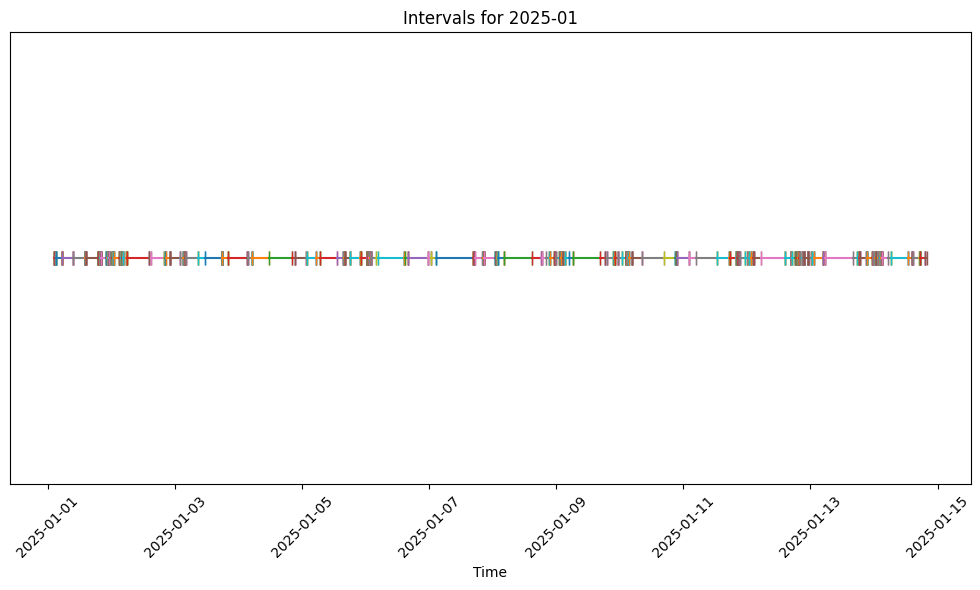

In [9]:
import matplotlib.pyplot as plt

def plot_intervals_for_month(intervals, year, month):
    # Filter intervals for the specified month
    month_intervals = intervals[
        (intervals['sampleDT'].dt.year == year) & 
        (intervals['sampleDT'].dt.month == month)
    ]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for _, row in month_intervals.iterrows():
        ax.plot([row['sampleDT'], row['endTime']], [1, 1], marker='|', markersize=10)

    ax.set_yticks([])
    ax.set_xlabel('Time')
    ax.set_title(f'Intervals for {year}-{month:02d}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
year = 2025
month = 1
plot_intervals_for_month(intervs, year, month)

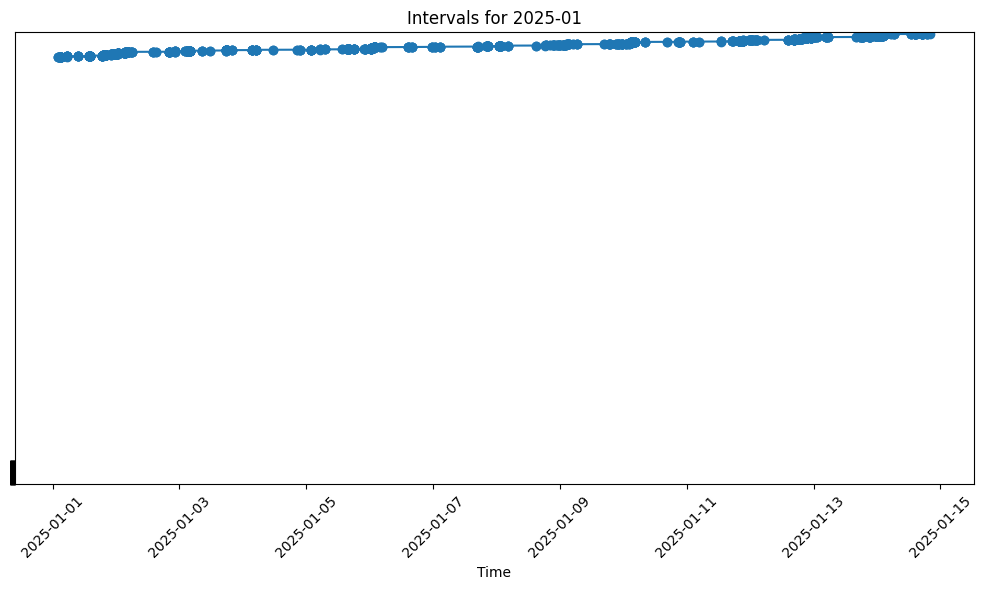

In [10]:
import matplotlib.pyplot as plt

def plot_intervals_for_month(intervals, year, month):
    # Filter intervals for the specified month
    month_intervals = intervals[
        (intervals['sampleDT'].dt.year == year) & 
        (intervals['sampleDT'].dt.month == month)
    ]

    # Prepare data for plotting
    x_values = []
    y_values = []
    for i, row in month_intervals.iterrows():
        x_values.extend([row['sampleDT'], row['endTime']])
        y_values.extend([i, i])  # Use the index as the y-value to separate lines

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x_values, y_values, marker='o')

    ax.set_yticks(range(len(month_intervals)))
    ax.set_yticklabels([])
    ax.set_xlabel('Time')
    ax.set_title(f'Intervals for {year}-{month:02d}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
year = 2025
month = 1
plot_intervals_for_month(intervs, year, month)

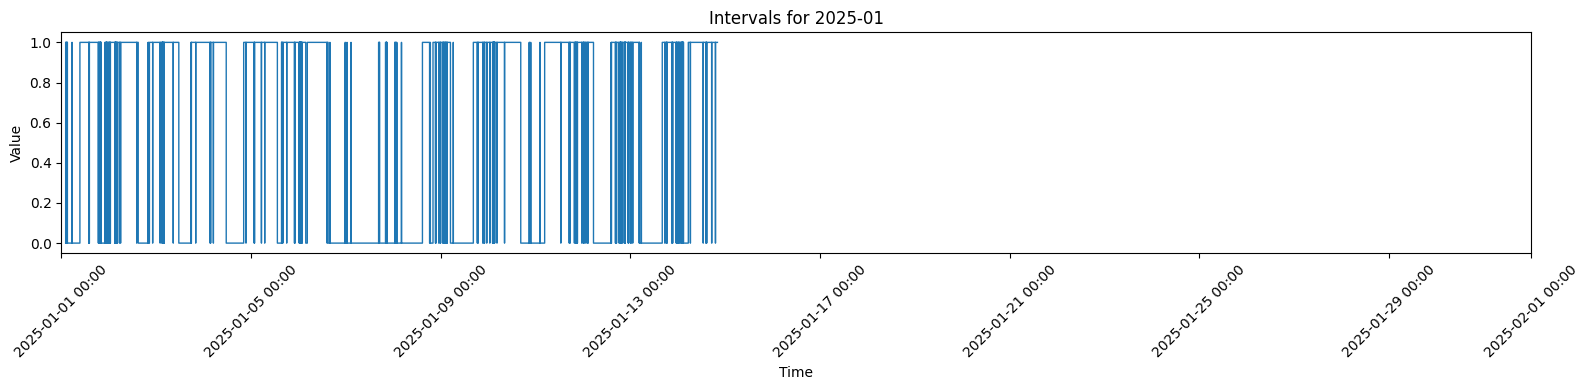

In [11]:
import matplotlib.pyplot as plt
import pytz
from datetime import datetime, timedelta

def plot_intervals_for_month(intervals, year, month, timezone='UTC'):
    # Filter intervals for the specified month
    month_intervals = intervals[
        (intervals['sampleDT'].dt.year == year) & 
        (intervals['sampleDT'].dt.month == month)
    ]

    # Prepare data for plotting
    values = []
    times = []
    for _, row in month_intervals.iterrows():
        times.append(row['sampleDT'])
        values.append(row['int!noData+0!data+1'])
        times.append(row['endTime'])
        values.append(row['int!noData+0!data+1'])

    # Plotting
    fig, ax = plt.subplots(figsize=(16.0, 4.0))

    plt.gca().set_title(f"Intervals for {year}-{month:02d}")
    plt.gca().set_xlim([datetime(year, month, 1, tzinfo=pytz.timezone(timezone)), 
                        datetime(year, month, 1, tzinfo=pytz.timezone(timezone)) + timedelta(days=31)])
    xFormatter = plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M', tz=pytz.timezone(timezone))
    plt.gca().xaxis.set_major_formatter(xFormatter)

    ax.plot(times, values, label='Interval', alpha=1, linewidth=1)

    plt.ylabel("Value")
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
year = 2025
month = 1
plot_intervals_for_month(intervs, year, month)

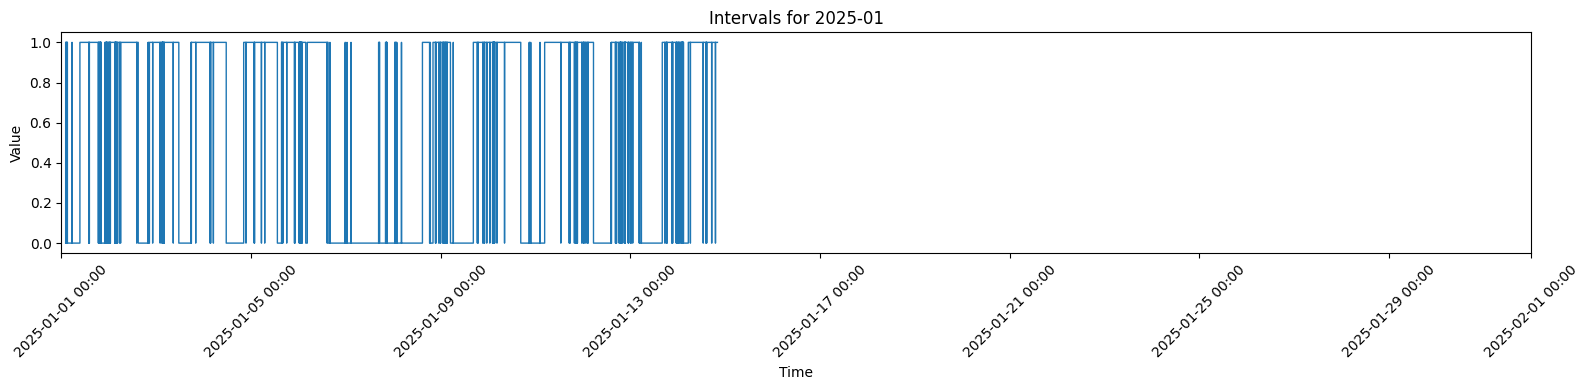

In [12]:
import matplotlib.pyplot as plt
import pytz
from datetime import datetime, timedelta
import mplcursors

def plot_intervals_for_month(intervals, year, month, timezone='UTC'):
    # Filter intervals for the specified month
    month_intervals = intervals[
        (intervals['sampleDT'].dt.year == year) & 
        (intervals['sampleDT'].dt.month == month)
    ]

    # Prepare data for plotting
    values = []
    times = []
    for _, row in month_intervals.iterrows():
        times.append(row['sampleDT'])
        values.append(row['int!noData+0!data+1'])
        times.append(row['endTime'])
        values.append(row['int!noData+0!data+1'])

    # Plotting
    fig, ax = plt.subplots(figsize=(16.0, 4.0))

    plt.gca().set_title(f"Intervals for {year}-{month:02d}")
    plt.gca().set_xlim([datetime(year, month, 1, tzinfo=pytz.timezone(timezone)), 
                        datetime(year, month, 1, tzinfo=pytz.timezone(timezone)) + timedelta(days=31)])
    xFormatter = plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M', tz=pytz.timezone(timezone))
    plt.gca().xaxis.set_major_formatter(xFormatter)

    ax.plot(times, values, label='Interval', alpha=1, linewidth=1)

    plt.ylabel("Value")
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add interactive cursor
    mplcursors.cursor(hover=True)

    plt.show()

# Example usage
year = 2025
month = 1
plot_intervals_for_month(intervs, year, month)

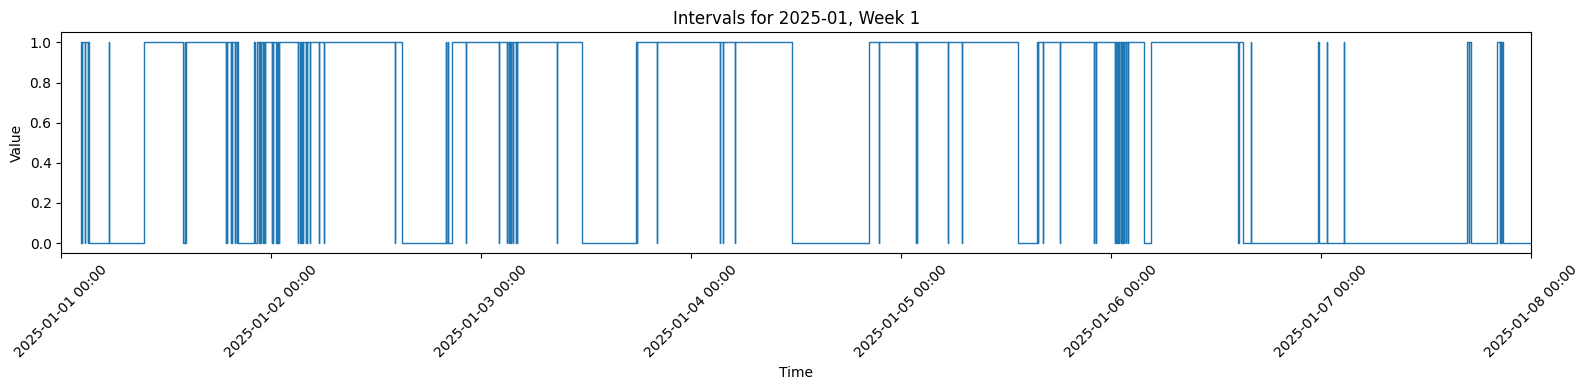

In [15]:
import matplotlib.pyplot as plt
import pytz
from datetime import datetime, timedelta
import mplcursors

def plot_intervals_for_week(intervals, year, month, week, timezone='UTC'):
    # Calculate the start and end dates for the specified week
    first_day_of_month = datetime(year, month, 1, tzinfo=pytz.timezone(timezone))
    start_of_week = first_day_of_month + timedelta(weeks=week-1)
    end_of_week = start_of_week + timedelta(days=7)

    # Filter intervals for the specified week
    week_intervals = intervals[
        (intervals['sampleDT'] >= start_of_week) & 
        (intervals['sampleDT'] < end_of_week)
    ]

    # Prepare data for plotting
    values = []
    times = []
    for _, row in week_intervals.iterrows():
        times.append(row['sampleDT'])
        values.append(row['int!noData+0!data+1'])
        times.append(row['endTime'])
        values.append(row['int!noData+0!data+1'])

    # Plotting
    fig, ax = plt.subplots(figsize=(16.0, 4.0))

    plt.gca().set_title(f"Intervals for {year}-{month:02d}, Week {week}")
    plt.gca().set_xlim([start_of_week, end_of_week])
    xFormatter = plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M', tz=pytz.timezone(timezone))
    plt.gca().xaxis.set_major_formatter(xFormatter)

    ax.plot(times, values, label='Interval', alpha=1, linewidth=1)

    plt.ylabel("Value")
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add interactive cursor
    mplcursors.cursor(hover=True)

    plt.show()

# Example usage
year = 2025
month = 1
week = 1
plot_intervals_for_week(intervs, year, month, week)

In [13]:
# what did I want to do with these intervals?
# determine where intervals for audio data were so I could query the aligned data struture better for actual audio

# query times when cameras were recording fast, slow, or not at all

# query intersecting HR intervals

# store hypnographs

# find gaps in air quality data

# TODO make separate read and write interval functions

In [14]:
# after I get my audio imported and intervaled
# pandas allows for non unique indicies 
# just don't deduplicate the data
# we can store the activites in a standard interval 